<div>
    <h2>1. setup, import library</h2>
</div>

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D,BatchNormalization, AveragePooling2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from tensorflow.keras.losses import SparseCategoricalCrossentropy, BinaryCrossentropy, CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adamax
from argparse import ArgumentParser
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, BackupAndRestore, LambdaCallback
import pickle
import matplotlib.pyplot as plt
import os, sys
from datetime import datetime
import numpy as np
import pytz
import json
import keras
import tensorflow as tf
import wandb
from wandb.keras import WandbMetricsLogger

import sys
sys.path.append("/kaggle/working/sgu24project/resnet_model")
import resnet_model

current_time = datetime.now()

# Convert to Vietnam time zone
vietnam_timezone = pytz.timezone('Asia/Ho_Chi_Minh')
current_time_vietnam = current_time.astimezone(vietnam_timezone)

# Format the datetime object to exclude milliseconds
current_time = str(current_time_vietnam.strftime('%Y-%m-%d %H:%M:%S'))

current_time = current_time.replace(" ","_")
current_time = current_time.replace("-","_")
current_time = current_time.replace(":","_")
current_time = current_time.replace("+","_")

print(current_time)
path_current = os.path.abspath(globals().get("__file__","."))
script_dir  = os.path.dirname(path_current)
print(script_dir)
root_path = os.path.abspath(f"{script_dir}/../../../")
experiments_dir = os.path.abspath(f"/kaggle/working/exps/Resnet/experiment_{current_time}")
data_path = "/kaggle/input/rafdb-basic-after-clustering/rafdb_basic_after_clustering"
print(experiments_dir)
print(data_path)

2024-04-23 20:23:49.800739: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-23 20:23:49.800856: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-23 20:23:49.927617: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2024_04_24_03_24_02
/kaggle
/kaggle/working/exps/Resnet/experiment_2024_04_24_03_24_02
/kaggle/input/rafdb-basic-after-clustering/rafdb_basic_after_clustering


<div>
    <h2>2. Exploring Data Analysis</h2>
    <h2>2.1. load Data</h2>
</div>

In [5]:
label_mapping  = {1: "Surprise", 2: "Fear", 3: "Disgust", 4: "Happiness", 5: "Sadness", 6: "Anger", 7: "Neutral"}
gender_mapping = {0: "male", 1: "female", 2: "unsure"}
race_mapping   = {0: "Caucasian", 1: "African-American", 2: "Asian"}
age_mapping    = {0: "0-3", 1: "4-19", 2: "20-39", 3: "40-69", 4: "70+"}
db = resnet_model.RafdbBasic(root_dir='/kaggle/input/rafdb-basic', 
                         db_file='/kaggle/working/sgu24project/rafdb_basic.hdf5', 
                         db_name='rafdb_basic')
data_train = db.db_data.loc[db.db_data['type'] == 'train']
data_test = db.db_data.loc[db.db_data['type'] == 'test']
print(f"Trainning images = {len(data_train)}")
print(f"Trainning images = {len(data_test)}")

label_mapping  = {1: "Surprise", 2: "Fear", 3: "Disgust", 4: "Happiness", 5: "Sadness", 6: "Anger", 7: "Neutral"}
gender_mapping = {0: "male", 1: "female", 2: "unsure"}
race_mapping   = {0: "Caucasian", 1: "African-American", 2: "Asian"}
age_mapping    = {0: "0-3", 1: "4-19", 2: "20-39", 3: "40-69", 4: "70+"}

Trainning images = 12271
Trainning images = 3068


<div>
    <h2>2.1.1. View data in tablute type</h2>
</div>

In [58]:
import tabulate
import copy
db_table = copy.copy(db.db_data)
db_table['emotion'] = db_table['emotion'].map(label_mapping)
db_table['gender'] = db_table['gender'].map(gender_mapping)
db_table['race'] = db_table['race'].map(race_mapping)
db_table['age'] = db_table['age'].map(age_mapping)
print(tabulate.tabulate(db_table[:50][['image_aligned','type','emotion','race','age','gender']], headers = 'keys', tablefmt = 'psql'))

+-------------+---------------------------------------+--------+-----------+------------------+-------+----------+
| id          | image_aligned                         | type   | emotion   | race             | age   | gender   |
|-------------+---------------------------------------+--------+-----------+------------------+-------+----------|
| train_00001 | Image/aligned/train_00001_aligned.jpg | train  | Sadness   | Caucasian        | 20-39 | female   |
| train_00002 | Image/aligned/train_00002_aligned.jpg | train  | Sadness   | Caucasian        | 20-39 | female   |
| train_00003 | Image/aligned/train_00003_aligned.jpg | train  | Happiness | Asian            | 20-39 | female   |
| train_00004 | Image/aligned/train_00004_aligned.jpg | train  | Happiness | Caucasian        | 20-39 | female   |
| train_00005 | Image/aligned/train_00005_aligned.jpg | train  | Sadness   | Asian            | 4-19  | female   |
| train_00006 | Image/aligned/train_00006_aligned.jpg | train  | Surprise  | Cau

<div>
    <h2>2.1.2. View some images in training set</h2>
</div>

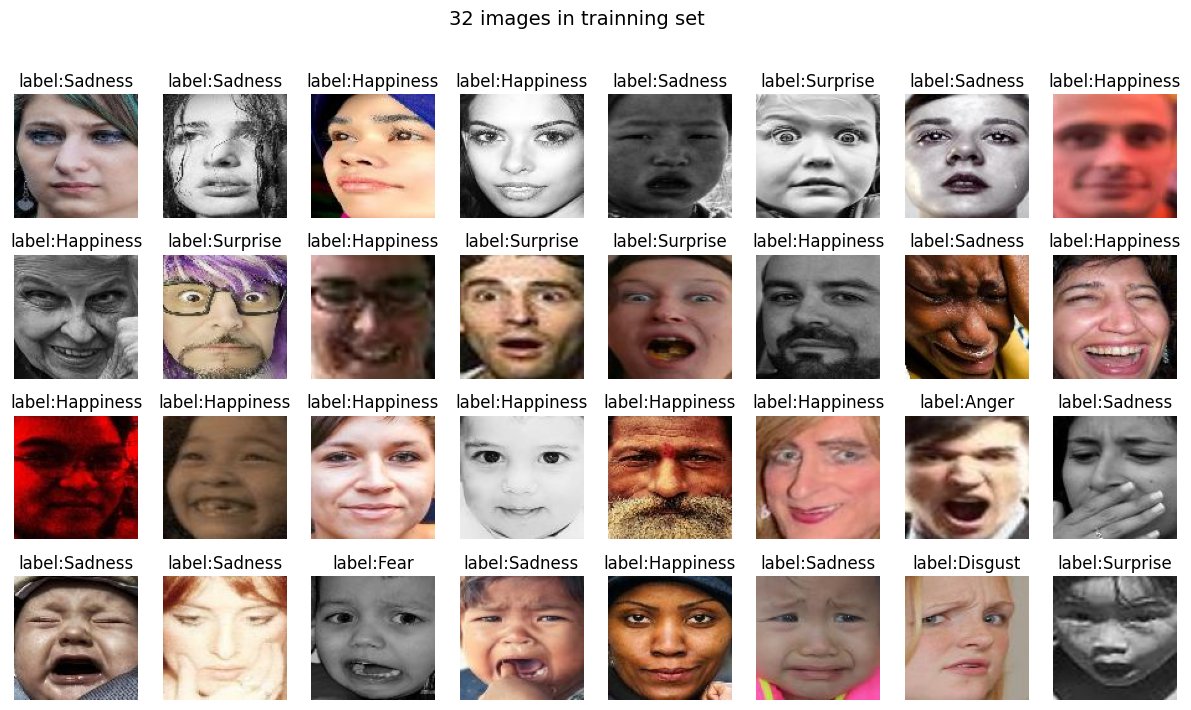

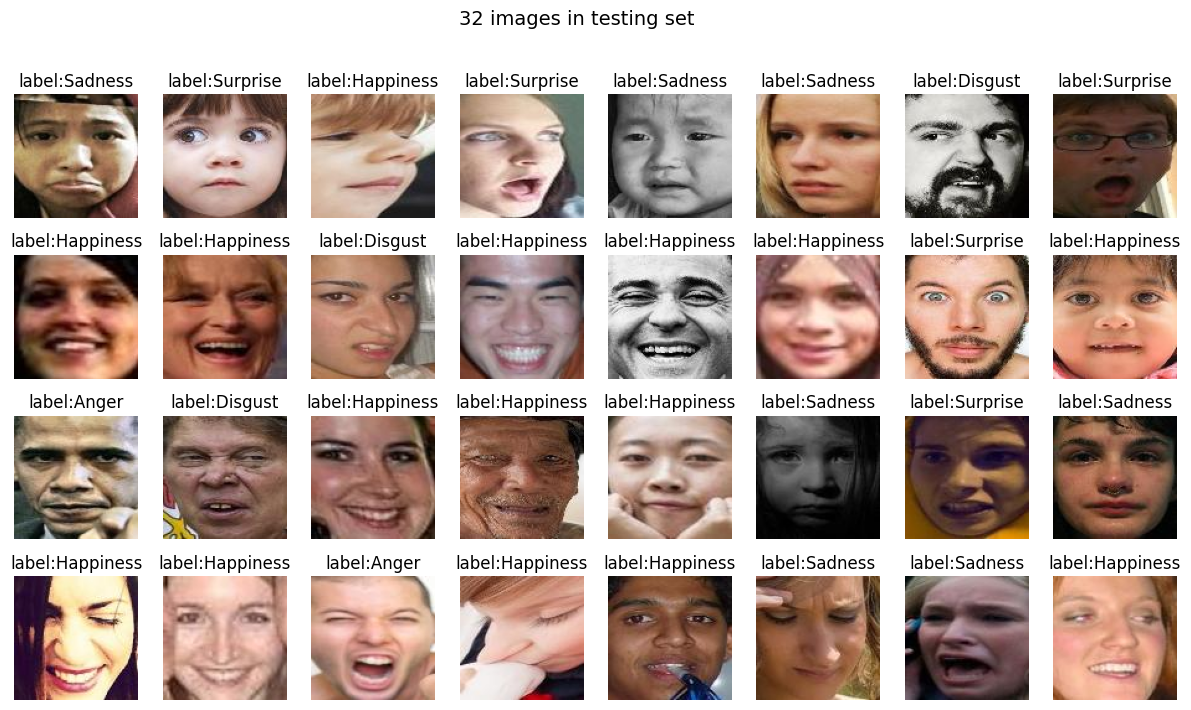

In [11]:
import random
import cv2
import matplotlib.pyplot as plt

def view_images_in_set_directory(data, data_root_path, nrow, ncol, type_set, random_mode = True):
    fig, ax = plt.subplots(nrow, ncol, figsize=(15, 8))
    fig.suptitle(f"{nrow * ncol} images in {type_set} set", fontsize=14)
    for i in range(nrow):
        for j in range(ncol):
            index = i * ncol + j  # Calculate the index for accessing data
            random_value = random.randint(2,len(data)-1) if random_mode == True  else index
            data_chose = data[random_value:random_value+1].iloc[0]
            image_path = data_root_path + data_chose['image_aligned']
            emotion = data_chose['emotion']
            image = cv2.imread(image_path)
            image = image[:,:,::-1]  # Convert BGR to RGB
            ax[i][j].imshow(image)
            ax[i][j].set_title(f'label:{label_mapping[emotion]}')
            ax[i][j].axis('off')
            
view_images_in_set_directory(data = data_train, data_root_path = '/kaggle/input/rafdb-basic/rafdb_basic/',
                   nrow = 4, ncol = 8, type_set = "trainning", random_mode = False)
plt.show()
print('\n'* 5)
view_images_in_set_directory(data = data_test, data_root_path = '/kaggle/input/rafdb-basic/rafdb_basic/',
                   nrow = 4, ncol = 8, type_set = "testing", random_mode = False)
plt.show()

<div>
    <h2>2.2. Pie Chart</h2>
</div>

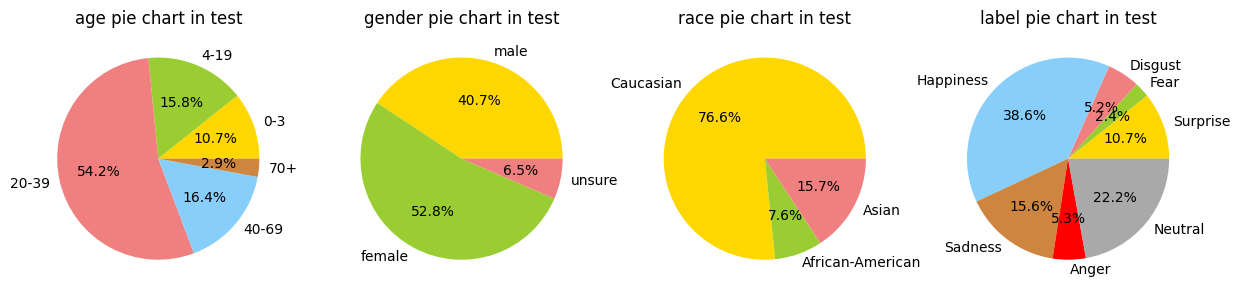

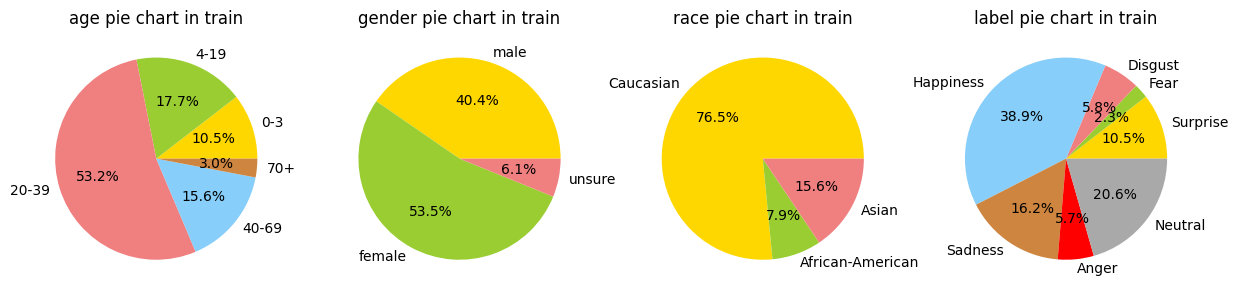

In [12]:
data_train = db.db_data.loc[db.db_data['type'] == 'train']
data_test = db.db_data.loc[db.db_data['type'] == 'test']
def pieChartInDataset(data, type):
    age_mapping_labels = [x for x in age_mapping.values()]
    age_mapping_sizes = []  # Represents percentages
    age_mapping_colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'peru']

    for i in age_mapping.keys():
        percent = len(data.loc[data['age'] == i]) / len(data)
        age_mapping_sizes.append(percent)


    #set data for race pie chart
    race_mapping_labels = [x for x in race_mapping.values()]
    race_mapping_sizes = []  # Represents percentages
    race_mapping_colors = ['gold', 'yellowgreen', 'lightcoral']

    for i in race_mapping.keys():
        percent = len(data.loc[data['race'] == i]) / len(data)
        race_mapping_sizes.append(percent)


    #set data for gender pie chart
    gender_mapping_labels = [x for x in gender_mapping.values()]
    gender_mapping_sizes = []  # Represents percentages
    gender_mapping_colors = ['gold', 'yellowgreen', 'lightcoral']

    for i in gender_mapping.keys():
        percent = len(data.loc[data['gender'] == i]) / len(data)
        gender_mapping_sizes.append(percent)


    #set data for label pie chart
    label_mapping_labels = [x for x in label_mapping.values()]
    label_mapping_sizes = []  # Represents percentages
    label_mapping_colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'peru','red','darkgray']

    for i in label_mapping.keys():
        percent = len(data.loc[data['emotion'] == i]) / len(data)
        label_mapping_sizes.append(percent)

   
    plt.figure(figsize=(15, 8))
    plt.subplot(1, 4, 1)
  
    plt.pie(age_mapping_sizes, labels=age_mapping_labels, colors=age_mapping_colors, autopct='%1.1f%%')
    plt.title(f'age pie chart in {type}')

    plt.subplot(1, 4, 2)
   
    plt.pie(gender_mapping_sizes, labels=gender_mapping_labels, colors=gender_mapping_colors, autopct='%1.1f%%')
    plt.title(f'gender pie chart in {type}')

    plt.subplot(1, 4, 3)
   
    plt.pie(race_mapping_sizes, labels=race_mapping_labels, colors=race_mapping_colors, autopct='%1.1f%%')
    plt.title(f'race pie chart in {type}')

    plt.subplot(1, 4, 4)
    plt.pie(label_mapping_sizes, labels=label_mapping_labels, colors=label_mapping_colors, autopct='%1.1f%%')
    plt.title(f'label pie chart in {type}')

pieChartInDataset(data_test, 'test')
pieChartInDataset(data_train, 'train')

<div>
    <h2>2.3. Column Chart</h2>
</div>

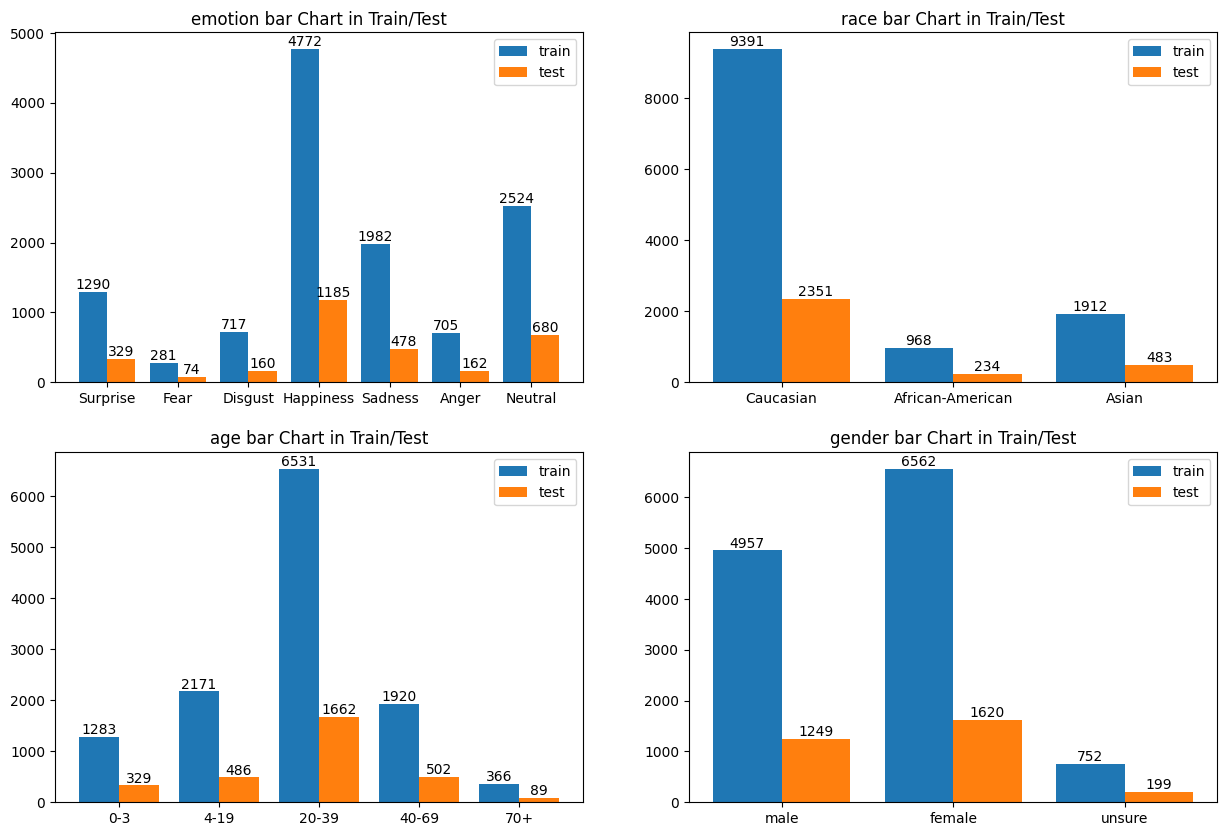

In [13]:
import matplotlib.pyplot as plt
import numpy as np
# Data
def barChart(mapping, attribute, indexPlt):
    xlabel1 = [x for x in mapping.values()]
    train_values = []
    test_values = []
    for i in mapping.keys():
        train_values.append(len(data_train.loc[data_train[attribute] == i]))
        test_values.append(len(data_test.loc[data_test[attribute] == i]))

    index = np.arange(len(xlabel1))
    bar_width = 0.4  # Width of each bar

    # Create subplot
    ax = plt.subplot(2, 2, indexPlt)

    # Plot bars
    ax.bar(index, train_values, width=bar_width, label='train')
    ax.bar(index + bar_width, test_values, width=bar_width, label='test')

    # Customize subplot
    ax.set_title(f'{attribute} bar Chart in Train/Test')
    ax.set_xticks(index + bar_width/2)  # Centering the x-ticks between bars
    ax.set_xticklabels(xlabel1)
    ax.legend()
    for i, v in enumerate(train_values):
        ax.text(i, v + 0.5, str(v), ha='center', va='bottom')
    for i, v in enumerate(test_values):
        ax.text(i + bar_width, v + 0.5, str(v), ha='center', va='bottom')
plt.figure(figsize=(15, 10)) 
barChart(label_mapping,'emotion',1)
barChart(race_mapping,'race',2)
barChart(age_mapping,'age',3)
barChart(gender_mapping,'gender',4)
plt.show()

<div>
    <h2>2.4. Heat Map</h2>
</div>

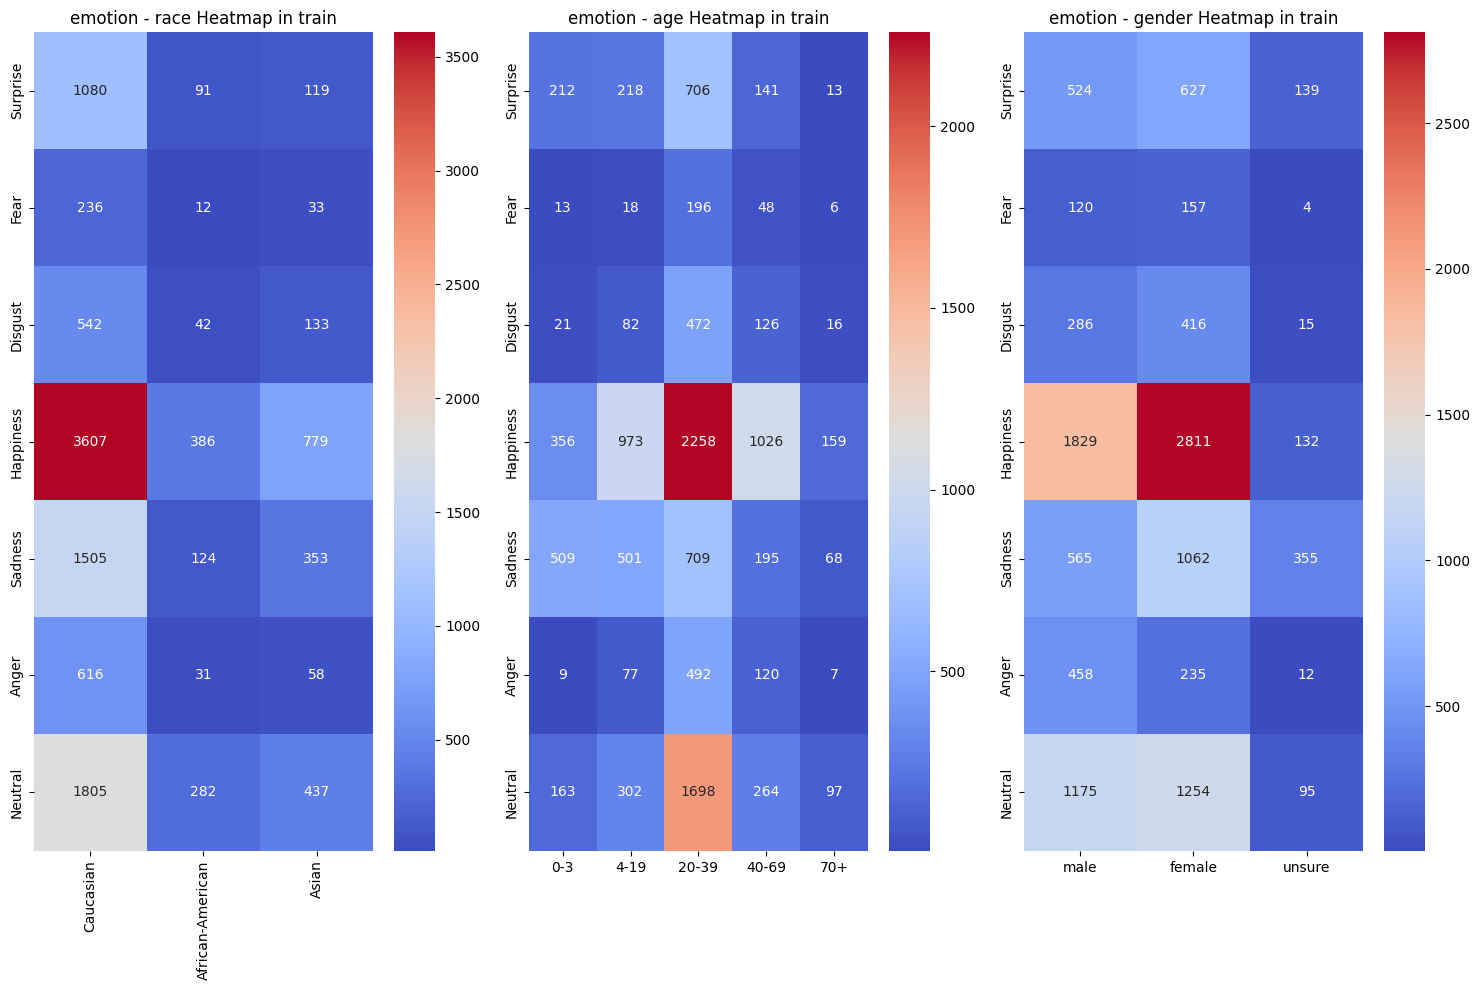

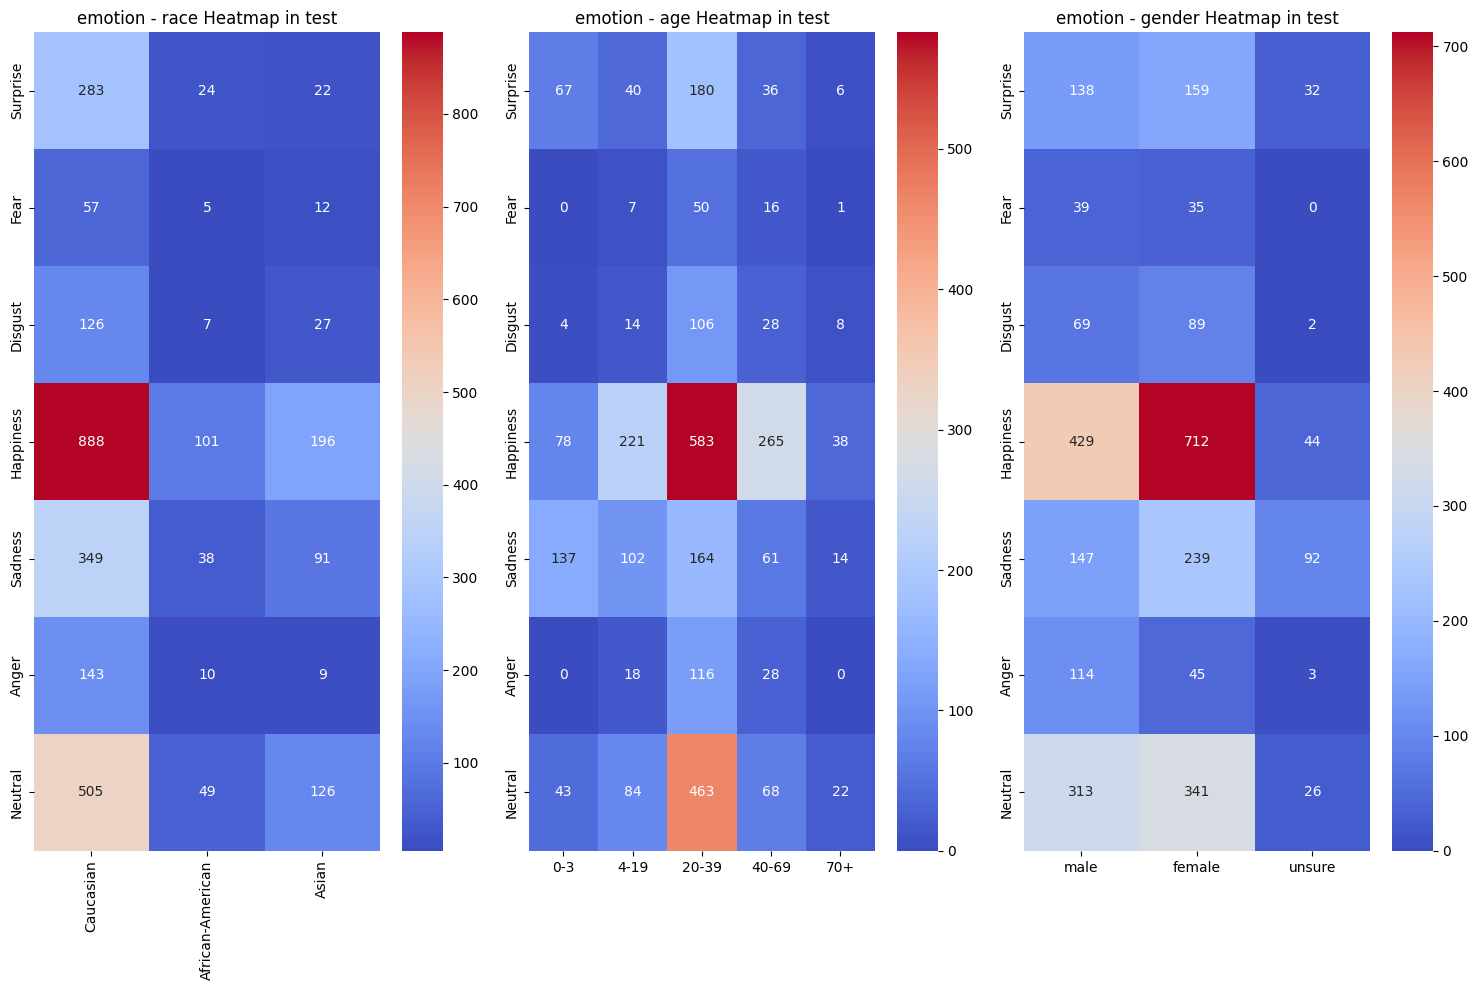

In [16]:
import seaborn as sns

def heatmapData(data, type):
    # emotion - race data
    label_race_heatMap = []
    for i in label_mapping.keys():
        labeli=[]
        for j in race_mapping.keys():
            labeli.append(len(data.loc[(data['emotion'] == i) & (data['race'] == j)]))
        label_race_heatMap.append(labeli)
    race_row_heatmap_map = [x for x in label_mapping.values()]
    race_col_heat_map = [x for x in race_mapping.values()]
   
    # emotion - age data
    label_age_heatMap = []
    for i in label_mapping.keys():
        labeli=[]
        for j in age_mapping.keys():
            labeli.append(len(data.loc[(data['emotion'] == i) & (data['age'] == j)]))
        label_age_heatMap.append(labeli)
    age_row_heatmap_map = [x for x in label_mapping.values()]
    age_col_heat_map = [x for x in age_mapping.values()]

    # emotion - gender data
    label_gender_heatMap = []
    for i in label_mapping.keys():
        labeli=[]
        for j in gender_mapping.keys():
            labeli.append(len(data.loc[(data['emotion'] == i) & (data['gender'] == j)]))
        label_gender_heatMap.append(labeli)
    gender_row_heatmap_map = [x for x in label_mapping.values()]
    gender_col_heat_map = [x for x in gender_mapping.values()]

    plt.figure(figsize=(15, 10))

    # Plotting the heatmap
    plt.subplot(1,3,1)
    sns.heatmap(label_race_heatMap, annot=True,fmt='.0f', cmap='coolwarm', yticklabels = race_row_heatmap_map, xticklabels = race_col_heat_map)
    plt.title(f'emotion - race Heatmap in {type}')

    plt.subplot(1,3,2)
    sns.heatmap(label_age_heatMap, annot=True, fmt='.0f', cmap='coolwarm', yticklabels = age_row_heatmap_map, xticklabels = age_col_heat_map)
    plt.title(f'emotion - age Heatmap in {type}')

    plt.subplot(1,3,3)
    sns.heatmap(label_gender_heatMap, annot=True, fmt='.0f', cmap='coolwarm', yticklabels = gender_row_heatmap_map, xticklabels = gender_col_heat_map)
    plt.title(f'emotion - gender Heatmap in {type}')

    plt.tight_layout()
    plt.show()

heatmapData(data_train, 'train')
heatmapData(data_test, 'test')

<div>
    <h2>2.5. Other diagrams</h2>
</div>

In [61]:
print("Do anything you want !")

Do anything you want !


<div>
    <h2>3. setup trainning</h2>
    <h2>3.1 Data augmentaion</h2>
</div>

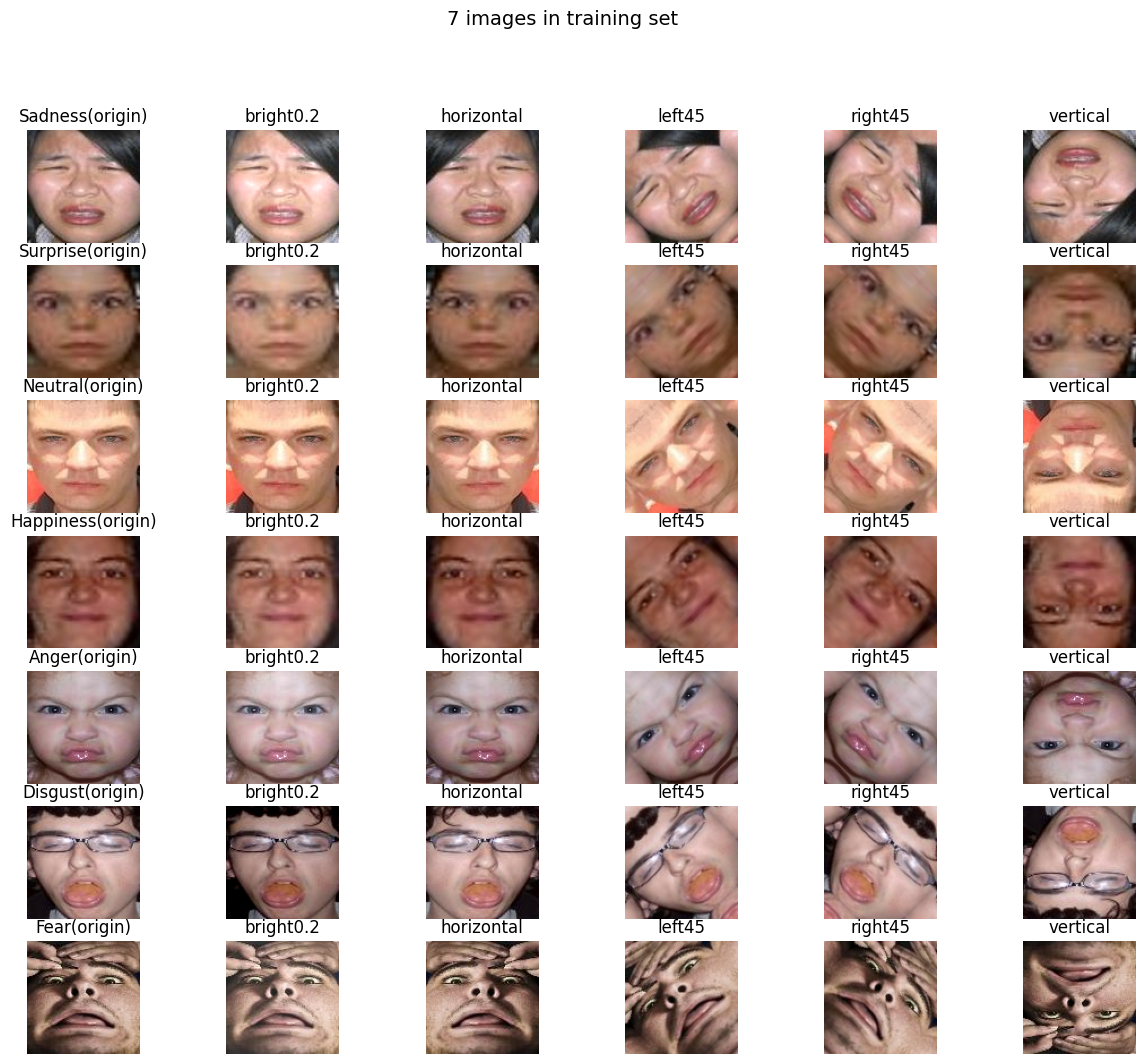

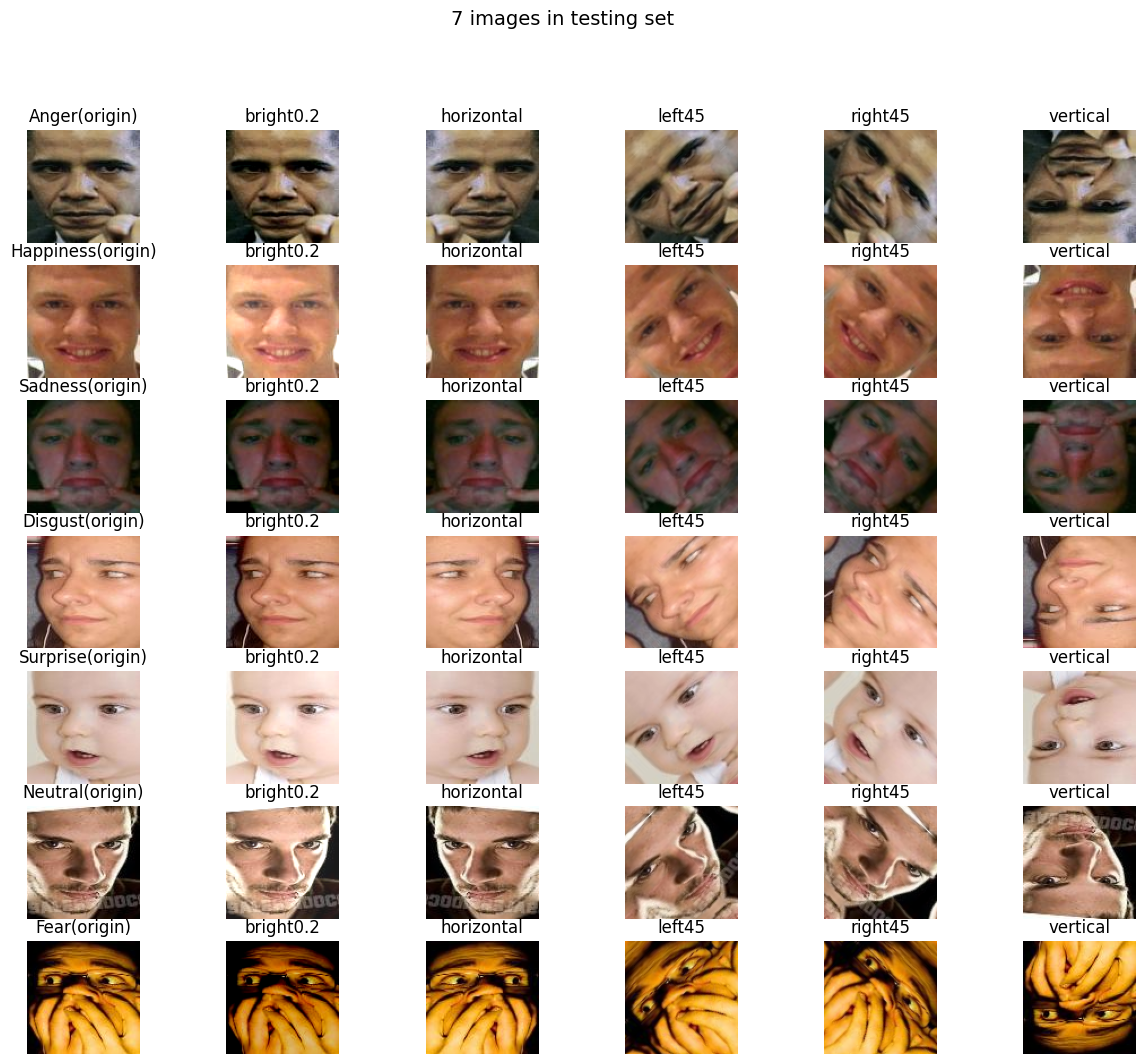

In [120]:
def view_images_in_set(data, data_root_path, type_set):
    fig, ax = plt.subplots(len(label_mapping), 6, figsize=(15, 12))
    fig.suptitle(f"{len(label_mapping)} images in {type_set} set", fontsize=14)
    emotion_chose = []
    j =0
    while len(emotion_chose) != len(label_mapping):
        random_value = random.randint(2,len(data)-1)
        data_chose = data[random_value:random_value+1].iloc[0]
        image_path = data_root_path + data_chose['image_aligned']
        emotion = data_chose['emotion']
        if emotion not in emotion_chose:
            emotion_chose.append(emotion)
        else:
            continue
        i = len(emotion_chose) - 1
        image = cv2.imread(image_path)
        image = image[:,:,::-1]  # Convert BGR to RGB
        
        ax[i][0].imshow(image)
        ax[i][0].set_title(f'{label_mapping[emotion]}(origin)')
        ax[i][0].axis('off')

        aug_image = resnet_model.train_aug_randomBrightnessContrast(image_size = image.shape[:2])(image = image)['image']
        ax[i][1].imshow(aug_image)
        ax[i][1].set_title(f'bright0.2')
        ax[i][1].axis('off')

        aug_image = resnet_model.train_aug_horizontal(image_size = image.shape[:2])(image = image)['image']
        ax[i][2].imshow(aug_image)
        ax[i][2].set_title(f'horizontal')
        ax[i][2].axis('off')

        aug_image = resnet_model.train_aug_left45(image_size = image.shape[:2])(image = image)['image']
        ax[i][3].imshow(aug_image)
        ax[i][3].set_title(f'left45')
        ax[i][3].axis('off')

        aug_image = resnet_model.train_aug_right45(image_size = image.shape[:2])(image = image)['image']
        ax[i][4].imshow(aug_image)
        ax[i][4].set_title(f'right45')
        ax[i][4].axis('off')

        aug_image = resnet_model.train_aug_verticalFlip(image_size = image.shape[:2])(image = image)['image']
        ax[i][5].imshow(aug_image)
        ax[i][5].set_title(f'vertical')
        ax[i][5].axis('off')
view_images_in_set(data = data_train, data_root_path = '/kaggle/input/rafdb-basic/rafdb_basic/', type_set ="training")
plt.show()
print('\n'*5)
view_images_in_set(data = data_test, data_root_path = '/kaggle/input/rafdb-basic/rafdb_basic/', type_set ="testing")
plt.show()

<div>
    <h2>3.2 setup Arguments</h2>
</div>

In [96]:
import argparse
#sys.argv = ["/kaggle/working/sgu24project/test.ipynb", "--model", "tuandeptrai","--model2","happy"] parsing args through .ipynb
import json
# Read the JSON file
with open(r'/kaggle/working/sgu24project/resnetParams.json') as f:
    data = json.load(f)
all_inital_argument = data

parser = argparse.ArgumentParser()
parser.add_argument('--model', default= all_inital_argument['model']['choose'], type=str, help='Type of model')
parser.add_argument('--train-folder', default= all_inital_argument['train-folder'], type=str, help='Where training data is located')
parser.add_argument('--valid-folder', default= all_inital_argument['valid-folder'], type=str, help='Where validation data is located')
parser.add_argument('--num-classes', default= all_inital_argument['num-classes'], type=int, help='Number of classes')
parser.add_argument("--batch-size", default= all_inital_argument['batch-size'], type=int)
parser.add_argument('--image-size', default= all_inital_argument['image-size'], type=int, help='Size of input image') # initial 224
parser.add_argument('--optimizer', default= all_inital_argument['optimizer']['choose'], type=str, help='Types of optimizers')
parser.add_argument('--lr', default=all_inital_argument['lr'], type = float, help='Learning rate')
parser.add_argument('--epochs', default= all_inital_argument['epochs'], type=int, help = 'Number of epochs')
parser.add_argument('--image-channels', default= all_inital_argument['image-chennels'], type=int, help='Number channel of input image')
parser.add_argument('--class-mode', default= all_inital_argument['class-mode']['choose'], type=str, help='Class mode to compile')
parser.add_argument('--model-path', default= all_inital_argument['model-path'], type=str, help='Path to save trained model')
    
parser.add_argument('--exp-dir', default = experiments_dir, type=str, help='folder contain experiemts')
parser.add_argument('--author-name', default= all_inital_argument['author-name'], type=str, help='name of an author')
parser.add_argument('--use-wandb', default= all_inital_argument['use-wandb'], type=int, help='Use wandb')
parser.add_argument('--debug', default= all_inital_argument['debug']['choose'], type=int, help='debug')
parser.add_argument('--transform-type', default = all_inital_argument['transform-type'], type=str, help='folder contain experiemts')
parser.add_argument('--wandb-api-key', default = all_inital_argument['wandb-api-key'], type=str, help='wantdb api key')
parser.add_argument('--wandb-project-name', default = all_inital_argument['wandb-project-name'], type=str, help='name project to store data in wantdb')
parser.add_argument('--d-steps', default= all_inital_argument['d-steps'], type=int, help='step per epochs')
parser.add_argument('--type-resnet', default= all_inital_argument['type-resnet']['choose'], type=int, help='0: Resnet, 1: CBAM_Resnet, 2: residual_resnet')
parser.add_argument('--early-stopping', default= all_inital_argument['early-stopping'], type=int, help='early stopping if n e-pochs not better!')
parser.add_argument('--lr-decrease', default= all_inital_argument['lr-decrease'], type=int, help='value learning rate decrease after 5 epochs not better')
args, unknown = parser.parse_known_args()
configs = vars(args)

<div>
    <h2>3.3 Data Loader</h2>
</div>

In [5]:
training_datagen = ImageDataGenerator(
        rescale=1. / 255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2)
val_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = training_datagen.flow_from_directory(args.train_folder, target_size=(args.image_size, args.image_size), batch_size= args.batch_size, class_mode = args.class_mode, shuffle = True)
val_generator = val_datagen.flow_from_directory(args.valid_folder, target_size=(224, 224), batch_size= args.batch_size, class_mode = args.class_mode, shuffle = True)

Found 12271 images belonging to 7 classes.
Found 3068 images belonging to 7 classes.


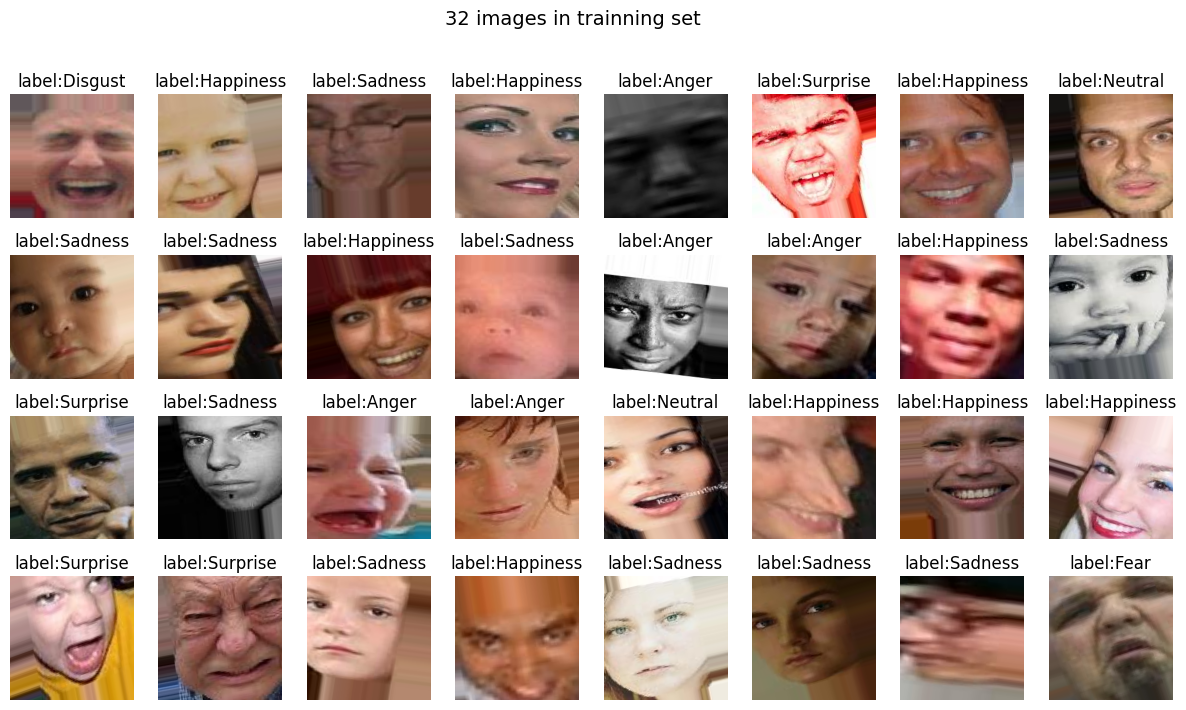

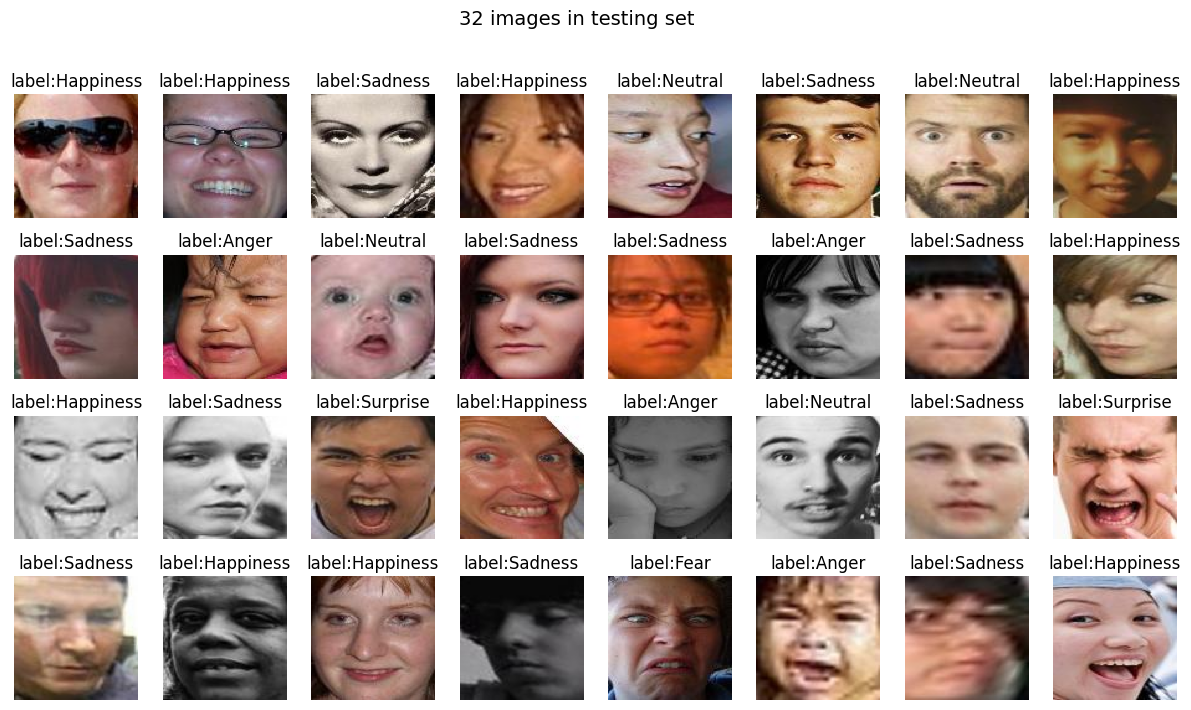

In [56]:
import cv2
def view_images_in_set_flow_from_directory(data_generator, nrow, ncol, type_set):
    fig, ax = plt.subplots(nrow, ncol, figsize=(15, 8))
    fig.suptitle(f"{nrow * ncol} images in {type_set} set", fontsize=14)
    batchs = iter(data_generator)
    for i in range(nrow):
        current_batch = next(batchs)
        for j in range(ncol):
            emotion = current_batch[1][j]
            index = i * ncol + j  # Calculate the index for accessing data
            image = current_batch[0][j]
            image = image[:,:,::]  # Convert BGR to RGB
            ax[i][j].imshow(image)
            ax[i][j].set_title(f'label:{label_mapping[int(emotion)+1]}')
            ax[i][j].axis('off')
            
view_images_in_set_flow_from_directory(data_generator = train_generator,nrow = 4, ncol = 8, type_set = "trainning")
plt.show()
print('\n'* 5)
view_images_in_set_flow_from_directory(data_generator = val_generator, nrow = 4, ncol = 8, type_set = "testing")
plt.show()

<div>
    <h2>3.4. models</h2>
</div>

In [8]:
# Create model
if args.model == 'resnet18':
    model = resnet_model.resnet18(num_classes = args.num_classes, type_resnet = args.type_resnet)
elif args.model == 'resnet34':
    model = resnet_model.resnet34(num_classes = args.num_classes, type_resnet = args.type_resnet)
elif args.model == 'resnet50':
    model = resnet_model.resnet50(num_classes = args.num_classes, type_resnet = args.type_resnet)
elif args.model == 'resnet101':
    model = resnet_model.resnet101(num_classes = args.num_classes, type_resnet = args.type_resnet)
elif args.model == 'resnet152':
    model = resnet_model.resnet152(num_classes = args.num_classes, type_resnet = args.type_resnet)
else:
    print('Wrong resnet name, please choose one of these model: resnet18, resnet34, resnet50, resnet101, resnet152')
    raise Exception("model resnet incorrect")
# save all arguments to json file
print(args.exp_dir)
os.makedirs(args.exp_dir, exist_ok=True)

args_dict = vars(args)

# Write dictionary to file
file_path = os.path.join(experiments_dir, "arguments.json")
print(file_path)
with open(file_path, 'w') as file:
    json.dump(args_dict, file, indent=4)

model.build(input_shape=(None, args.image_size, args.image_size, args.image_channels))
#model.summary()


if (args.optimizer == 'adam'):
    optimizer = Adam(learning_rate=args.lr)
elif (args.optimizer == 'sgd'):
    optimizer = SGD(learning_rate=args.lr)
elif (args.optimizer == 'rmsprop'):
    optimizer = RMSprop(learning_rate=args.lr)
elif (args.optimizer == 'adadelta'):
    optimizer = Adadelta(learning_rate=args.lr)
elif (args.optimizer == 'adamax'):
    optimizer = Adamax(learning_rate=args.lr)
else:
    raise 'Invalid optimizer. Valid option: adam, sgd, rmsprop, adadelta, adamax'

model.compile(optimizer=optimizer, 
            loss=SparseCategoricalCrossentropy(),
            metrics=['accuracy'])

/kaggle/working/exps/Resnet/experiment_2024_04_23_05_31_43
/kaggle/working/exps/Resnet/experiment_2024_04_23_05_31_43/arguments.json


<div>
    <h2>3.5. Set up callbacks</h2>
</div>

In [9]:
from keras.callbacks import Callback,ReduceLROnPlateau
# callbacks
callbacks = []

# wandb
if args.use_wandb == 1:
    cb_wandb = WandbMetricsLogger(log_freq=1)
    callbacks.append(cb_wandb)

# best_model
save_bestmodel_path = f'{args.exp_dir}/{args.model_path}'
cb_best_model = ModelCheckpoint(save_bestmodel_path,
                             save_weights_only=False,
                             monitor='val_loss',
                             verbose=1,
                             mode='min',
                             save_best_only=True)
callbacks.append(cb_best_model)

# backup
backup_dir = f'{args.exp_dir}'
cb_backup = BackupAndRestore(backup_dir)
#callbacks.append(cb_backup)

# logger
cb_log = CSVLogger(f'{args.exp_dir}/log.csv')
callbacks.append(cb_log)
#early stopping
callbacks.append(keras.callbacks.EarlyStopping(monitor='loss',patience=args.early_stopping))       
          
# learning rate reduce after 5 epchs without loss decrease
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
callbacks.append(lr_scheduler)

steps_per_epoch = None
epochs = args.epochs
if args.debug == 1:
    steps_per_epoch = args.d_steps
    

<div>
    <h2>4. Training model</h2>
</div>

In [10]:
# Traning
model.fit(
    train_generator,
    epochs=epochs,
    verbose=1,
    steps_per_epoch = steps_per_epoch,
    validation_data=val_generator,
    callbacks=callbacks,
    validation_steps= steps_per_epoch
    )

# 🐝 Close your wandb run 
if args.use_wandb == 1:
    wandb.finish()
    

Epoch 1/120


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-04-22 22:34:47.553963: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[64,1024,14,14]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,2048,7,7]{3,2,1,0}, f32[2048,1024,1,1]{3,2,1,0}), window={size=1x1 stride=2x2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-04-22 22:34:47.558295: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.004522978s
Trying algorithm eng0{} for conv (f32[64,1

192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3610 - loss: 2.1123

W0000 00:00:1713825605.780435     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_loss improved from inf to 14.73185, saving model to /kaggle/working/exps/Resnet/experiment_2024_04_23_05_31_43/best_model.h5.keras


W0000 00:00:1713825636.185690     124 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


192/192 ━━━━━━━━━━━━━━━━━━━━ 403s 2s/step - accuracy: 0.3611 - loss: 2.1109 - val_accuracy: 0.2216 - val_loss: 14.7318 - learning_rate: 0.0010
Epoch 2/120
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 874ms/step - accuracy: 0.3946 - loss: 1.6584
Epoch 2: val_loss improved from 14.73185 to 1.84059, saving model to /kaggle/working/exps/Resnet/experiment_2024_04_23_05_31_43/best_model.h5.keras
192/192 ━━━━━━━━━━━━━━━━━━━━ 182s 917ms/step - accuracy: 0.3946 - loss: 1.6583 - val_accuracy: 0.3908 - val_loss: 1.8406 - learning_rate: 0.0010
Epoch 3/120
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 873ms/step - accuracy: 0.4092 - loss: 1.6147
Epoch 3: val_loss improved from 1.84059 to 1.56801, saving model to /kaggle/working/exps/Resnet/experiment_2024_04_23_05_31_43/best_model.h5.keras
192/192 ━━━━━━━━━━━━━━━━━━━━ 182s 916ms/step - accuracy: 0.4092 - loss: 1.6147 - val_accuracy: 0.3947 - val_loss: 1.5680 - learning_rate: 0.0010
Epoch 4/120
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 871ms/step - accuracy: 0.3975 - loss: 1.5814
Epoch

<div>
    <h2>5. Training model</h2>
    <h2>5.1 Result in log.csv</h2>
</div>

   epoch  accuracy      loss  val_accuracy   val_loss
0      0  0.375764  1.847686      0.221643  14.731847
1      1  0.397523  1.643098      0.390808   1.840595


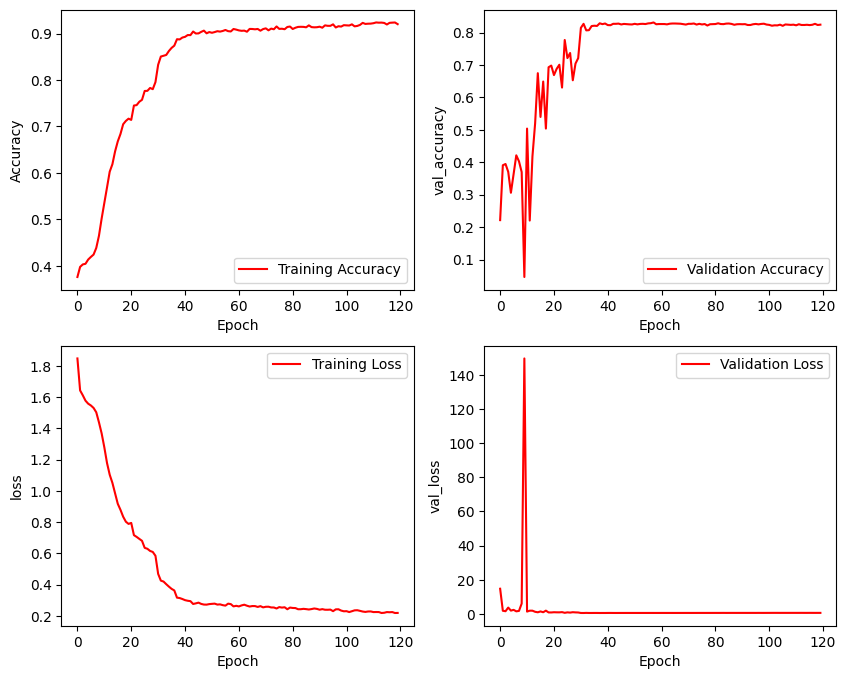

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
result = pd.read_csv("/kaggle/working/exps/Resnet/experiment_2024_04_23_05_31_43/log.csv")

plt.figure(figsize=(10, 8))

# Plotting Accuracy
plt.subplot(2, 2, 1)
plt.plot(result['epoch'], result['accuracy'], label='Training Accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(result['epoch'], result['val_accuracy'], label='Validation Accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('val_accuracy')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(result['epoch'], result['loss'], label='Training Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(result['epoch'], result['val_loss'], label='Validation Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('val_loss')
plt.legend()

<div>
    <h2>5.2 Result in best_model.h5.keras</h2>
</div>

In [2]:
from keras.models import load_model
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

model_file_path = "/kaggle/working/exps/Resnet/experiment_2024_04_23_05_31_43/best_model.h5.keras"
test_dir = '/kaggle/input/rafdb-basic-after-clustering/rafdb_basic_after_clustering/test'
model = keras.models.load_model(model_file_path)
    
val_datagen = ImageDataGenerator(rescale=1. / 255)
val_generator = val_datagen.flow_from_directory(test_dir, 
                                                target_size=(224, 224), batch_size=64, 
                                                class_mode='sparse', 
                                                shuffle=False)#remember shuffle = false

Found 3068 images belonging to 7 classes.


<div>
    <h2>5.2.1 Read and view confusion matrix</h2>
</div>

In [3]:
def GetConfusionMatrix(model, dataloader):
    ground_truth_labels = dataloader.classes
    
    predictions = model.predict(dataloader)
    predicted_labels = np.argmax(predictions, axis=1)  # Convert softmax probabilities to class labels


    # Generate confusion matrix
    conf_matrix = confusion_matrix(ground_truth_labels, predicted_labels)
    return conf_matrix
matrix = GetConfusionMatrix(model = model, dataloader  = val_generator)

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 2/48 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step

I0000 00:00:1713903931.250681     109 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1713903931.294391     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


48/48 ━━━━━━━━━━━━━━━━━━━━ 42s 699ms/step


Average diagnose = 0.8269230769230769


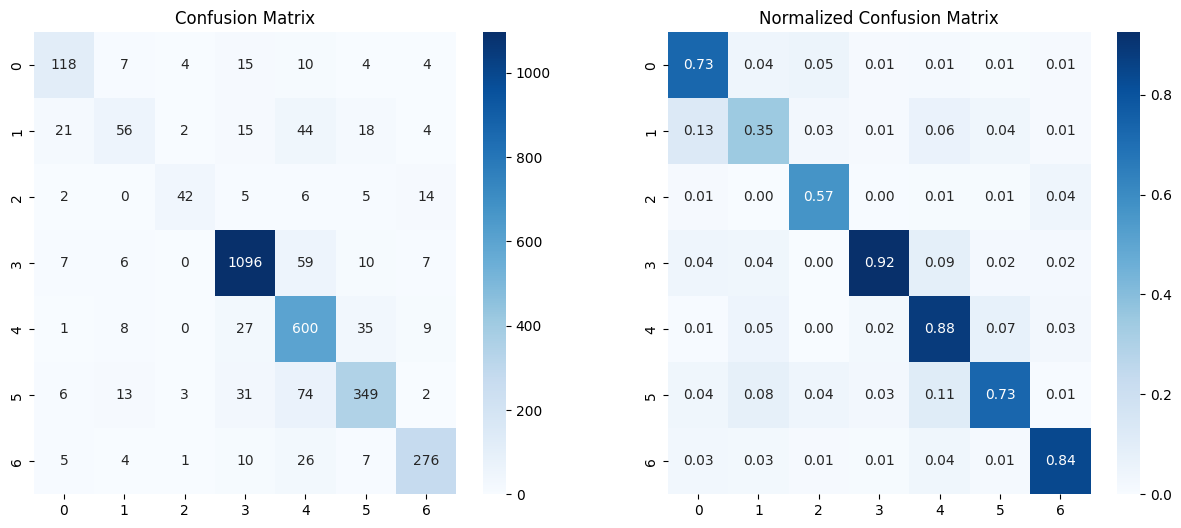

In [72]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


def InformationMatrix(matrix):
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))  # Create a single row with two columns for the subplots

    axes[0].set_title('Confusion Matrix')
    sns.heatmap(matrix, ax=axes[0], cmap='Blues', annot=True, fmt="d")
    

    conf_matrix_normalize = matrix / matrix.astype(np.float32).sum(axis=1)
    axes[1].set_title('Normalized Confusion Matrix')
    sns.heatmap(conf_matrix_normalize, ax=axes[1], cmap='Blues', annot=True, fmt=".2f")  # Plot the normalized confusion matrix

    total = matrix.sum()
    average_diagnose = np.trace(matrix) / total
    print(f"Average diagnose = {average_diagnose}")

    plt.show()
InformationMatrix(matrix)

<div>
    <h2>5.2.2 Read and view F1-score, recall, precision</h2>
</div>

In [78]:
from sklearn.metrics import classification_report
import pandas as pd
def View_Basic_Validation_Measure(model, dataloader):
    ground_truth_labels = dataloader.classes
    predictions = model.predict(dataloader)
    predicted_labels = np.argmax(predictions, axis=1)
    report = classification_report(y_true = ground_truth_labels, y_pred = predicted_labels, output_dict=True)
    view_report = pd.DataFrame(report).transpose()
    print(view_report)
View_Basic_Validation_Measure(model = model, dataloader  = val_generator)

48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step
              precision    recall  f1-score      support
0              0.737500  0.728395  0.732919   162.000000
1              0.595745  0.350000  0.440945   160.000000
2              0.807692  0.567568  0.666667    74.000000
3              0.914095  0.924895  0.919463  1185.000000
4              0.732601  0.882353  0.800534   680.000000
5              0.815421  0.730126  0.770419   478.000000
6              0.873418  0.838906  0.855814   329.000000
accuracy       0.826923  0.826923  0.826923     0.826923
macro avg      0.782353  0.717463  0.740966  3068.000000
weighted avg   0.825639  0.826923  0.822154  3068.000000


<div>
    <h2>5.2.3 collect 20 images predict true label and 20 images predict false label</h2>
</div>

In [109]:
import matplotlib.pyplot as plt
import shutil
label_mapping  = {1: "Surprise", 2: "Fear", 3: "Disgust", 4: "Happiness", 5: "Sadness", 6: "Anger", 7: "Neutral"}
def SaveImageTrueNFalse(model, dataloader, save_path, n=20, extention_file ='.jpg'):
    true_images_dir = save_path+"/true_images/"
    false_images_dir = save_path+"/false_images/"
    shutil.rmtree(true_images_dir, ignore_errors=True)
    shutil.rmtree(false_images_dir, ignore_errors=True)
    os.makedirs(true_images_dir, exist_ok=True)
    os.makedirs(false_images_dir, exist_ok=True)

    ground_truth_labels = dataloader.classes
    
    predictions = model.predict(val_generator)
    predicted_labels = np.argmax(predictions, axis=1)  # Convert softmax probabilities to class labels
    

    all_images = []
    for i in range(len(dataloader)):
        batch_images, batch_labels = dataloader[i]
        for j in batch_images:
            all_images.append(j)
    all_images = np.array(all_images)
    collected=[1,0]
    for i in range(len(all_images)):
        path_image_save = ''
        if collected[0] != 20 and  ground_truth_labels[i] == predicted_labels[i]:
            path_image_save = true_images_dir + label_mapping[ground_truth_labels[i]+1] + f'_{i}'
            collected[0] = collected[0] +1
        if collected[1] != 20 and  ground_truth_labels[i] != predicted_labels[i]:
            path_image_save = false_images_dir + f'true_{label_mapping[ground_truth_labels[i]+1]}_predict_{label_mapping[predicted_labels[i]+1]}_{i}'
            collected[1] = collected[1] +1
        if path_image_save != '':
            plt.imsave(path_image_save + extention_file, all_images[i])
    print("20 correctly predicted image, 20 wrong prediction image saved in {save_path}")
        
SaveImageTrueNFalse(model = model, dataloader  = val_generator, save_path ="/kaggle/working/exps/Resnet/experiment_2024_04_23_05_31_43", extention_file ='.jpg')

48/48 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step
20 correctly predicted image, 20 wrong prediction image


<div>
    <h1 style='margin-left:200px'>------------------------------  END!  ------------------------------</h2>
</div>